# PESTPP-GLM

In [31]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu


In [17]:
t_d = "template"
m_d = "master_glm"

In [18]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
pp_ss1,pp_ss1,log,67,0,1,-1,0.5
vka7_cn,vka7_cn,log,1,0,1,-1,0.5
ss6_cn,ss6_cn,log,1,0,1,-1,0.5
pp_vka1,pp_vka1,log,67,0,1,-1,0.5
grss4,grss4,log,705,0,1,-1,0.5
strk,strk,log,40,0,2,-2,1
grrech2,grrech2,log,705,0,0.0413927,-0.0457575,0.0217875
sy8_cn,sy8_cn,log,1,0,0.243038,-0.60206,0.211275
grvka4,grvka4,log,705,0,1,-1,0.5
grsy4,grsy4,log,705,0,0.243038,-0.60206,0.211275


### reduce the number of adjustable parameters

In [19]:
par = pst.parameter_data

In [20]:
# grid-scale pars
gr_pars = par.loc[par.pargp.apply(lambda x: "gr" in x),"parnme"]
par.loc[gr_pars,"partrans"] = "fixed"
pst.npar_adj

1011

In [21]:
strk_pars = par.loc[par.pargp=="strk","parnme"]
p1 = strk_pars.iloc[0]
par.loc[strk_pars.iloc[1:],"partrans"] = "tied"
par.loc[strk_pars.iloc[1:],"partied"] = p1
pst.npar_adj

972

In [22]:
par.loc[par.pargp.apply(lambda x: "pp" in x),"pargp"].unique()

array(['pp_hk0', 'pp_hk1', 'pp_hk2', 'pp_rech0', 'pp_rech1', 'pp_ss0',
       'pp_ss1', 'pp_ss2', 'pp_sy0', 'pp_sy1', 'pp_sy2', 'pp_vka0',
       'pp_vka1', 'pp_vka2'], dtype=object)

In [23]:
s_pars = par.loc[par.pargp.apply(lambda x: "pp" in x and ("ss" in x or "sy" in x)),"parnme"]
par.loc[s_pars,"partrans"] = "fixed"
pst.npar_adj

570

In [24]:
adj_par = par.loc[par.partrans=="log",:]
adj_par.pargp.value_counts().sort_values()

vka6_cn         1
sy6_cn          1
ss7_cn          1
hk6_cn          1
rech5_cn        1
strk            1
hk7_cn          1
sy8_cn          1
ss8_cn          1
hk8_cn          1
vka7_cn         1
rech4_cn        1
vka8_cn         1
ss6_cn          1
flow            1
sy7_cn          1
welflux         2
welflux_k02     6
drncond_k00    10
pp_hk2         67
pp_hk0         67
pp_vka2        67
pp_vka1        67
pp_hk1         67
pp_rech0       67
pp_rech1       67
pp_vka0        67
Name: pargp, dtype: int64

In [25]:
fi_grps = ["pp_rech1","pp_vka0","pp_vka2"]
par.loc[par.pargp.apply(lambda x: x in fi_grps),"partrans"] = "fixed"
pst.npar_adj

369

In [26]:
pst.control_data.noptmax = 6
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 6
pst.pestpp_options["num_reals"] = 100
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

In [27]:
pyemu.os_utils.start_slaves(t_d,"pestpp-glm","freyberg_pp.pst",num_slaves=20,slave_root=".",
                            master_dir=m_d)

In [28]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

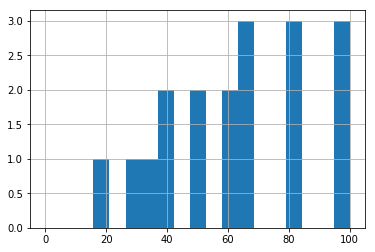

In [29]:
ax = oe.phi_vector.hist(bins=np.linspace(0,100,20))


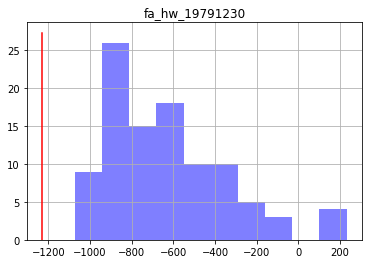

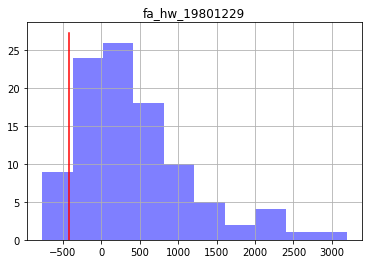

In [30]:
obs = pst.observation_data
swgws = obs.loc[obs.obsnme.apply(lambda x: "fa_hw" in x),"obsnme"]
for swgw in swgws:
    ax = plt.subplot(111)
    #oe_pr.loc[:,swgw].hist(ax=ax,color="0.5",alpha=0.5)
    oe.loc[:,swgw].hist(ax=ax,color="b",alpha=0.5)
    ax.plot([obs.loc[swgw,"obsval"],obs.loc[swgw,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(swgw)
    plt.show()